In [1]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import tensorflow.keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD 
from tensorflow.keras.callbacks import EarlyStopping
import itertools
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Dropout

from utils import downcast

In [2]:
road_num = int(input())

1


In [3]:
cols = ['road_num', 'current_speed', 'free_flow_speed', 'speed_diff', 'current_travel_time', 
        'free_flow_travel_time', 'time_diff', 'creation_date']

df = pd.read_csv('data/flow.csv', usecols=cols, parse_dates=['creation_date'])
df = downcast(df)

df = df[df['road_num'] == road_num].copy()
df = df.drop_duplicates('creation_date')
df = df.reset_index(drop=True)
df = df.drop(['road_num'], axis=1)
df = df.set_index('creation_date')

# df = df[['speed_diff', 'current_speed', 'free_flow_speed',
#          'current_travel_time', 'free_flow_travel_time', 'time_diff']]

In [4]:
df.shape

(13230, 6)

In [5]:
df.head()

,current_speed,free_flow_speed,speed_diff,current_travel_time,free_flow_travel_time,time_diff
creation_date,,,,,,
2018-07-24 14:58:54,25,25,0,124,124,0
2018-07-24 14:58:55,25,25,0,124,124,0
2018-07-24 15:46:31,19,25,6,163,124,39
2018-07-24 16:01:31,25,25,0,124,124,0
2018-07-24 16:47:06,18,25,7,172,124,48


In [6]:
df.isnull().sum()

current_speed            0
free_flow_speed          0
speed_diff               0
current_travel_time      0
free_flow_travel_time    0
time_diff                0
dtype: int64

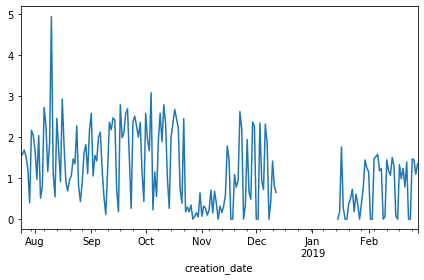

In [7]:
df['speed_diff'].resample('D').mean().plot() 
plt.tight_layout()
plt.show() 

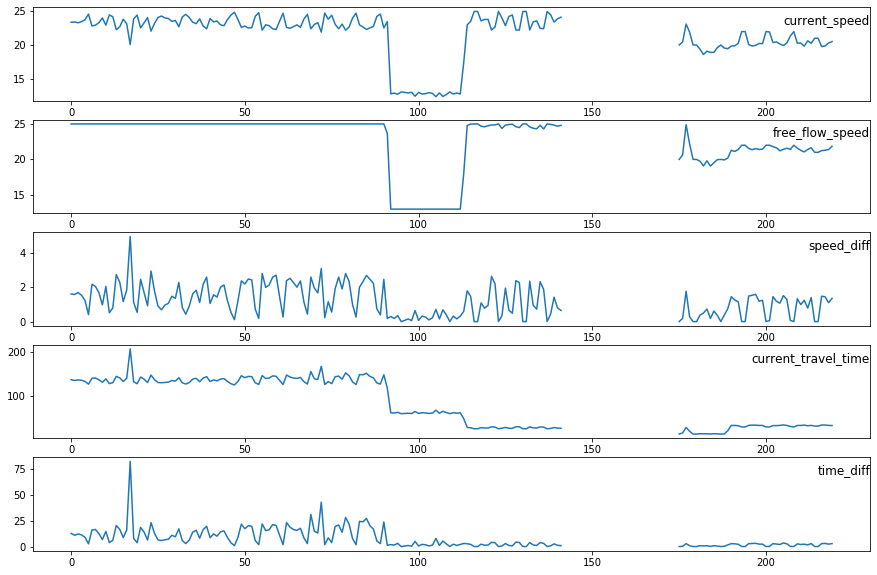

In [8]:
# Below I compare the mean of different featuresresampled over day. 
# specify columns to plot
cols = [0, 1, 2, 3, 5]
i = 1
groups=cols
values = df.resample('D').mean().values
# plot each column
plt.figure(figsize=(15, 10))
for group in groups:
    plt.subplot(len(cols), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.75, loc='right')
    i += 1
plt.show()

In [9]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [10]:
## resampling of data over hour
df_resample = df.resample('h').mean() 
df_resample.shape

(5266, 6)

In [11]:
## * Note: I scale all features in range of [0,1].

## If you would like to train based on the resampled data (over hour), then used below
values = df_resample.values 


## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)
1   0.953846   0.923077   0.000000   0.156265        1.0   0.000000  0.676923
2   0.676923   0.923077   0.290323   0.211168        1.0   0.065072  0.792308
3   0.792308   0.923077   0.169355   0.190052        1.0   0.040044  0.642308
4   0.642308   0.923077   0.326613   0.242492        1.0   0.102197  0.873077
5   0.873077   0.923077   0.084677   0.173158        1.0   0.020022  0.953846


In [12]:
# split into train and test sets
values = reframed.values

n_train_time = 365*10
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(3650, 1, 6) (3650,) (778, 1, 6) (778,)


Train on 3650 samples, validate on 778 samples
Epoch 1/20
3650/3650 - 1s - loss: 0.2766 - val_loss: 0.0506
Epoch 2/20
3650/3650 - 0s - loss: 0.0319 - val_loss: 0.0188
Epoch 3/20
3650/3650 - 0s - loss: 0.0259 - val_loss: 0.0115
Epoch 4/20
3650/3650 - 0s - loss: 0.0199 - val_loss: 0.0072
Epoch 5/20
3650/3650 - 0s - loss: 0.0160 - val_loss: 0.0052
Epoch 6/20
3650/3650 - 0s - loss: 0.0139 - val_loss: 0.0045
Epoch 7/20
3650/3650 - 0s - loss: 0.0124 - val_loss: 0.0044
Epoch 8/20
3650/3650 - 0s - loss: 0.0116 - val_loss: 0.0043
Epoch 9/20
3650/3650 - 0s - loss: 0.0117 - val_loss: 0.0043
Epoch 10/20
3650/3650 - 0s - loss: 0.0117 - val_loss: 0.0043
Epoch 11/20
3650/3650 - 0s - loss: 0.0116 - val_loss: 0.0043
Epoch 12/20
3650/3650 - 0s - loss: 0.0113 - val_loss: 0.0043
Epoch 13/20
3650/3650 - 0s - loss: 0.0115 - val_loss: 0.0043
Epoch 14/20
3650/3650 - 0s - loss: 0.0114 - val_loss: 0.0043
Epoch 15/20
3650/3650 - 0s - loss: 0.0109 - val_loss: 0.0043
Epoch 16/20
3650/3650 - 0s - loss: 0.0114 - val

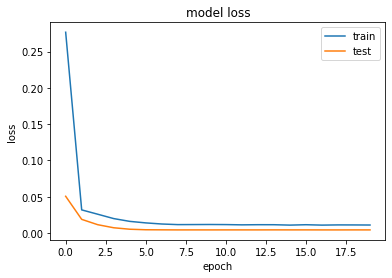

Test RMSE: 1.420


In [13]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 6))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -5:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

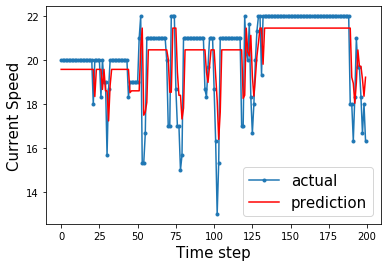

In [16]:
aa=[x for x in range(200)]
plt.plot(aa, inv_y[:200], marker='.', label="actual")
plt.plot(aa, inv_yhat[:200], 'r', label="prediction")
plt.ylabel('Current Speed', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()